# NBA Re-Scoring

In [80]:
#%pip install -r requirements.txt

In [81]:
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Thank you to https://github.com/DomSamangy/NBA_Shots_04_25 

In [82]:
df = pl.read_csv('NBA_2004_2025_Shots.csv')
print(f"# Rows: {len(df)}")
print(f"Shape: {df.shape}")

# Rows: 4443714
Shape: (4443714, 24)


In [83]:
df = df.drop(["EVENT_TYPE", "ACTION_TYPE", "SHOT_TYPE", "BASIC_ZONE", "ZONE_NAME", "ZONE_ABB", "ZONE_RANGE", "QUARTER", "MINS_LEFT", "SECS_LEFT"])
df.head

<bound method DataFrame.head of shape: (4_443_714, 14)
┌──────────┬──────────┬────────────┬───────────────┬───┬───────────┬───────┬───────┬───────────────┐
│ SEASON_1 ┆ SEASON_2 ┆ TEAM_ID    ┆ TEAM_NAME     ┆ … ┆ SHOT_MADE ┆ LOC_X ┆ LOC_Y ┆ SHOT_DISTANCE │
│ ---      ┆ ---      ┆ ---        ┆ ---           ┆   ┆ ---       ┆ ---   ┆ ---   ┆ ---           │
│ i64      ┆ str      ┆ i64        ┆ str           ┆   ┆ bool      ┆ f64   ┆ f64   ┆ i64           │
╞══════════╪══════════╪════════════╪═══════════════╪═══╪═══════════╪═══════╪═══════╪═══════════════╡
│ 2025     ┆ 2024-25  ┆ 1610612737 ┆ Atlanta Hawks ┆ … ┆ false     ┆ 16.8  ┆ 25.75 ┆ 26            │
│ 2025     ┆ 2024-25  ┆ 1610612737 ┆ Atlanta Hawks ┆ … ┆ false     ┆ 13.6  ┆ 5.15  ┆ 13            │
│ 2025     ┆ 2024-25  ┆ 1610612737 ┆ Atlanta Hawks ┆ … ┆ true      ┆ -15.7 ┆ 25.55 ┆ 25            │
│ 2025     ┆ 2024-25  ┆ 1610612737 ┆ Atlanta Hawks ┆ … ┆ false     ┆ 17.6  ┆ 23.65 ┆ 25            │
│ 2025     ┆ 2024-25  ┆ 1610612737 ┆

In [84]:
def draw_court(ax=None, color='black', lw=1):
    if ax is None:
        ax = plt.gca()

    # Hoop (inner diameter 18in)
    hoop_center_y = 5.25
    hoop = patches.Circle((0, hoop_center_y), radius=9/12, linewidth=lw, color=color, fill=False)

    # Three-point line (22ft away, 14up, then 23.75 radius around hoop)
    corner_three_a = patches.Rectangle((-22, 0), 0, 14, linewidth=lw, color=color)
    corner_three_b = patches.Rectangle((22, 0), 0, 14, linewidth=lw, color=color)
    three_arc = patches.Arc((0, hoop_center_y), 47.5, 47.5, theta1=22, theta2=158, linewidth=lw, color=color)

    # Center court (Circles 94/2 ft up, 6ft and 2ft radius)
    center_outer = patches.Circle((0, 94/2), radius=6, linewidth=lw, color=color, fill=False)
    center_inner = patches.Circle((0, 94/2), radius=2, linewidth=lw, color=color, fill=False)
    halfcourt = patches.Rectangle((-25, 94/2), 50, 0, linewidth=lw, color=color, fill=False)
    
    # Opposite 3pt line
    opp_corner_three_a = patches.Rectangle((-22, 0), 0, 14, linewidth=lw, color=color, angle=180, rotation_point=(0,94/2))
    opp_corner_three_b = patches.Rectangle((22, 0), 0, 14, linewidth=lw, color=color, angle=180, rotation_point=(0,94/2))
    opp_three_arc = patches.Arc((0, 94-hoop_center_y), 47.5, 47.5, theta2=360-22, theta1=360-158, linewidth=lw, color=color)

    # Boundary (94ft by 50ft)
    boundary = patches.Rectangle((-25, 0), 50, 94, linewidth=lw, color=color, fill=False)

    court_elements = [hoop, corner_three_a, corner_three_b, three_arc, halfcourt, boundary, opp_corner_three_a, opp_corner_three_b, opp_three_arc]
    for element in court_elements:
        ax.add_patch(element)

    return ax

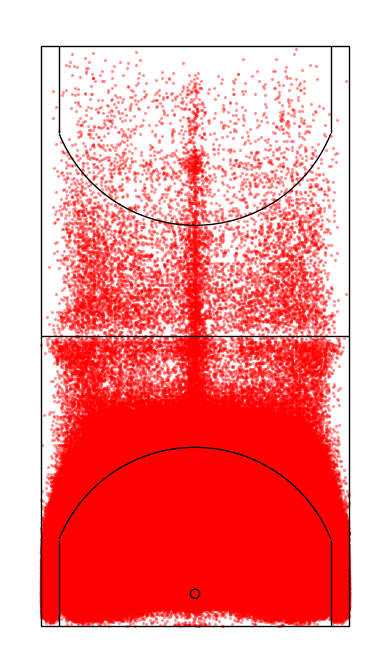

In [85]:
plt.figure(figsize=(4, 8))
ax = plt.gca()
ax.set_aspect('equal')

# Plot shots
plt.scatter(df["LOC_X"], df["LOC_Y"], alpha=0.3, s=2, color="red")

# Draw the court
draw_court(ax)

# Formatting
plt.xlim(-30, 30)
plt.ylim(-5, 100)
plt.axis('off')  # Hide axis ticks
plt.tight_layout()
plt.show()

In [86]:
# Function to calculate shot probability based on distance range from df
def calculate_shot_probability(df, d1, d2):
    # Filter shots within the distance range
    filtered_shots = df.filter((df["SHOT_DISTANCE"] >= d1) & (df["SHOT_DISTANCE"] <= d2))
    
    # Calculate the probability of making a shot in this range
    total_shots = len(filtered_shots)
    made_shots = len(filtered_shots.filter(filtered_shots["SHOT_MADE"] == True))
    
    if total_shots == 0:
        return 0.0  # Avoid division by zero
    
    return made_shots / total_shots

In [ ]:
shot_prob_24_25 = calculate_shot_probability(df, 24, 25)
print(shot_prob_24_25)

0.36305252265644317


In [88]:
twopt_shot_prob = calculate_shot_probability(df, 0, 20)
twopt_shot_value = twopt_shot_prob * 2 # TODO use SHOT_TYPE filtering
threept_shot_prob = calculate_shot_probability(df, 24, 25)
threept_shot_value = threept_shot_prob * 3
print(f"2pt EV: {twopt_shot_value}")
print(f"3pt EV: {threept_shot_value}")

2pt EV: 1.0058101302209463
3pt EV: 1.0891575679693295


In [91]:
eightyft_shot_prob = calculate_shot_probability(df, 80, 200)
print(f"Probability from 80ft: {eightyft_shot_prob}")
targetEV = 1
eightyft_points = targetEV / eightyft_shot_prob
print(f"Deserved points for Target EV of {targetEV}: {eightyft_points}")

Probability from 80ft: 0.007547169811320755
Deserved points for Target EV of 1: 132.5
